## Pêndulo invertido

Baseado no exemplo 5D do livro:

Friedland, B. (2012). *Control System Design: An Introduction to State-Space Methods.* Estados Unidos: Dover Publications.

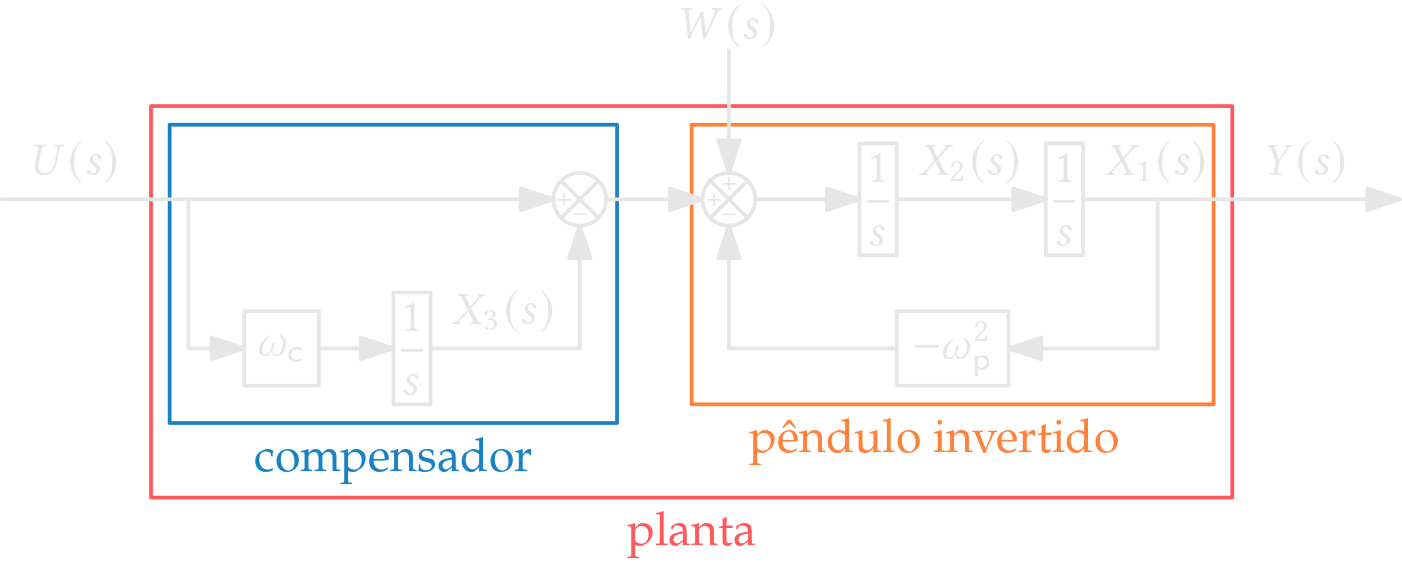

In [1]:
# !pip install sympy
# !pip install control
# !pip install tbcontrol
# !pip install ipywidgets

In [2]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
import scipy.signal as sg
import control as ct
import ipywidgets as widgets
from ipywidgets import interactive

In [ ]:
# Paleta de cores
cp = {
    'red': (1.0, 0.349, 0.369, 1.0),
    'green': (0.541, 0.788, 0.149, 1.0),
    'blue': (0.098, 0.510, 0.769, 1.0),
    'lred': (1.0, 0.588, 0.6, 1.0),
    'lgreen': (0.722, 0.894, 0.443, 1.0),
    'lblue': (0.369, 0.706, 0.918, 1.0),
    'orange': (1.0, 0.506, 0.227, 1.0),
    'yellow': (1.0, 0.792, 0.227, 1.0),
    'pink': (1.0, 0.349, 0.611, 1.0),
    'purple': (0.416, 0.298, 0.576, 1.0),
    'turquoise': (0.098, 0.761, 0.769, 1.0),
    'brown': (0.576, 0.380, 0.298, 1.0)
}

### Sistema na forma de espaço de estados

In [ ]:
ω_p, ω_c = sp.symbols('ω_p ω_c')

In [ ]:
A = sp.Matrix([[0, 1, 0],
                [ω_p**2, 0, -1],
                [0, 0, 0]])

B = sp.Matrix([[0], [1], [ω_c]])

C = sp.Matrix([[1, 0, 0]])

D = sp.Matrix([[0]])

E = sp.Matrix([[0], [1], [0]])

In [ ]:
An = sp.lambdify((ω_p), A)
Bn = sp.lambdify((ω_c), B)

### Transformação de variáveis que diagonaliza A

In [ ]:
V, Λ = A.diagonalize()
T = V.inv()

In [ ]:
Λ

Matrix([
[0,    0,   0],
[0, -ω_p,   0],
[0,    0, ω_p]])

In [ ]:
V

Matrix([
[ω_p**(-2), -1/ω_p, 1/ω_p],
[        0,      1,     1],
[        1,      0,     0]])

In [ ]:
T

Matrix([
[     0,   0,          1],
[-ω_p/2, 1/2,  1/(2*ω_p)],
[ ω_p/2, 1/2, -1/(2*ω_p)]])

In [ ]:
Λ - T*A*T.inv()

Matrix([
[0, 0, 0],
[0, 0, 0],
[0, 0, 0]])

In [ ]:
B_ = T*B
B_

Matrix([
[               ω_c],
[ ω_c/(2*ω_p) + 1/2],
[-ω_c/(2*ω_p) + 1/2]])

In [ ]:
C_ = C*T.inv()
C_

Matrix([[ω_p**(-2), -1/ω_p, 1/ω_p]])

### Testes de Controlabilidade e Observabilidade

##### Forma de espaço de estados original $(A, B, C)$ 

In [ ]:
Q = sp.Matrix([[B, A*B, A*A*B]])
Q

Matrix([
[  0,    1,   -ω_c],
[  1, -ω_c, ω_p**2],
[ω_c,    0,      0]])

In [ ]:
Q.det().simplify()

ω_c*(-ω_c**2 + ω_p**2)

A matriz $Q$ se torna singular e, consequentemente, o sistema se torna **não-controlável** se, e somente se: 
* $\omega_c = 0$, ou 
* $\omega_c = - \omega_p$, ou
* $\omega_c = + \omega_p$.

In [ ]:
N = sp.Matrix([[C.T, A.T*C.T, A.T*A.T*C.T]])
N

Matrix([
[1, 0, ω_p**2],
[0, 1,      0],
[0, 0,     -1]])

In [ ]:
N.det().simplify()

-1

A matriz $N$ não será singular em nenhum cenário e, portanto, o sistema é **observável**.

Altenativamente, pode-se usar as funções `control.ctrb` e `control.obsv` para construir as matrizes teste de controlabilidade e observabilidade.

In [ ]:
# matriz de controlabilidade 
ct.ctrb(An(1), Bn(-1))

array([[ 0.,  1.,  1.],
       [ 1.,  1.,  1.],
       [-1.,  0.,  0.]])

In [ ]:
# posto da matriz de controlabilidade
np.linalg.matrix_rank(ct.ctrb(An(1), Bn(-1)))

2

In [ ]:
# matriz de observabilidade
ct.obsv(An(1), C)

array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 1.,  0., -1.]])

##### Forma de espaço de estados após transformação de variáveis $(\Lambda, \bar B, \bar C)$ 

In [ ]:
Q_ = sp.Matrix([[B_, Λ*B_, Λ*Λ*B_]])
Q_

Matrix([
[               ω_c,                        0,                           0],
[ ω_c/(2*ω_p) + 1/2, -ω_p*(ω_c/(2*ω_p) + 1/2),  ω_p**2*(ω_c/(2*ω_p) + 1/2)],
[-ω_c/(2*ω_p) + 1/2, ω_p*(-ω_c/(2*ω_p) + 1/2), ω_p**2*(-ω_c/(2*ω_p) + 1/2)]])

Na forma transformada fica evidente que:
* $\omega_c = 0$ torna a primeira linha de $\bar Q$ identicamente nula, 
* $\omega_c = - \omega_p$ torna a segunda linha de $\bar Q$ identicamente nula,
* $\omega_c = + \omega_p$ torna a terceira linha de $\bar Q$ identicamente nula;
evidenciando os três possíveis valores de  $\omega_c$ que tornam o sistema não-controlável.

### Síntese de um regulador por alocação de polos

In [ ]:
# Polinômio característico do sistema não-controlado (MA)
p = A.charpoly()
p

PurePoly(lambda**3 - ω_p**2*lambda, lambda, domain='ZZ[ω_p]')

In [ ]:
# Coeficientes do polinômio característico do sistema não-controlado (MA)
a = p.all_coeffs()
a

[1, 0, -ω_p**2, 0]

In [ ]:
# Matriz Toeplitz triangular W 
W = sp.Matrix([[1, a[1], a[2]],
               [0, 1, a[1]],
               [0, 0, 1]])
W

Matrix([
[1, 0, -ω_p**2],
[0, 1,       0],
[0, 0,       1]])

Suponha que se deseje alocar os polos de malha fechada nas posições:
* $s = - r$, 
* $s = - ζ ω_n + j ω_n \sqrt{1-ζ^2}$,
* $s = - ζ ω_n - j ω_n \sqrt{1-ζ^2}$.

In [ ]:
# Polos desejados para alocação em MF 
λ, ζ, ω_n, r = sp.symbols('λ ζ ω_n r')
p_ = sp.PurePoly((λ + r) * ((λ + ζ*ω_n)**2 + ω_n**2 * (1 - ζ**2)), λ)
a_ = p_.all_coeffs()
a_

[1, r + 2*ζ*ω_n, 2*r*ζ*ω_n + ω_n**2, r*ω_n**2]

In [ ]:
# Cálculo do ganho pela fórmula de Bass-Gura
k = ((Q*W).inv()).T * (sp.Matrix(a_[1:]) - sp.Matrix(a[1:]))
kn = sp.lambdify((ω_p, ω_c, ζ, ω_n, r), k)
k

Matrix([
[-r*ω_c*ω_n**2/(ω_c**2 - ω_p**2) - ω_c*ω_p**2*(r + 2*ζ*ω_n)/(ω_c**2 - ω_p**2) - ω_p**2*(2*r*ζ*ω_n + ω_n**2 + ω_p**2)/(ω_c**2 - ω_p**2)],
[           -r*ω_n**2/(ω_c**2 - ω_p**2) - ω_c*(2*r*ζ*ω_n + ω_n**2 + ω_p**2)/(ω_c**2 - ω_p**2) - ω_p**2*(r + 2*ζ*ω_n)/(ω_c**2 - ω_p**2)],
[       r*ω_n**2/(ω_c**3 - ω_c*ω_p**2) + ω_c*(r + 2*ζ*ω_n)/(ω_c**2 - ω_p**2) + ω_c*(2*r*ζ*ω_n + ω_n**2 + ω_p**2)/(ω_c**3 - ω_c*ω_p**2)]])

In [ ]:
# Exemplo de valor numérico para a matriz de ganho k
kn(1, 2, 0.707, 1, 1)

array([[-3.414],
       [-3.414],
       [ 2.914]])

In [ ]:
# Matrix de estados em MF
A_c = A - B*k.T
A_cn = sp.lambdify((ω_p, ω_c, ζ, ω_n, r), A_c)
A_c

Matrix([
[                                                                                                                                            0,                                                                                                                                 1,                                                                                                                                     0],
[r*ω_c*ω_n**2/(ω_c**2 - ω_p**2) + ω_c*ω_p**2*(r + 2*ζ*ω_n)/(ω_c**2 - ω_p**2) + ω_p**2 + ω_p**2*(2*r*ζ*ω_n + ω_n**2 + ω_p**2)/(ω_c**2 - ω_p**2),         r*ω_n**2/(ω_c**2 - ω_p**2) + ω_c*(2*r*ζ*ω_n + ω_n**2 + ω_p**2)/(ω_c**2 - ω_p**2) + ω_p**2*(r + 2*ζ*ω_n)/(ω_c**2 - ω_p**2),   -r*ω_n**2/(ω_c**3 - ω_c*ω_p**2) - ω_c*(r + 2*ζ*ω_n)/(ω_c**2 - ω_p**2) - ω_c*(2*r*ζ*ω_n + ω_n**2 + ω_p**2)/(ω_c**3 - ω_c*ω_p**2) - 1],
[ -ω_c*(-r*ω_c*ω_n**2/(ω_c**2 - ω_p**2) - ω_c*ω_p**2*(r + 2*ζ*ω_n)/(ω_c**2 - ω_p**2) - ω_p**2*(2*r*ζ*ω_n + ω_n**2 + ω_p**2)/(ω_c**2 - ω_p**2)), -ω_c*(-r*ω_n**2/(ω_c**2 -

In [ ]:
np.linalg.eig(A_cn(1, 2, 0.707, 1, 1))

EigResult(eigenvalues=array([-1.   +0.j        , -0.707+0.70721355j, -0.707-0.70721355j]), eigenvectors=array([[ 7.07106781e-01+0.j        , -2.90795535e-01+0.49630018j,
        -2.90795535e-01-0.49630018j],
       [-7.07106781e-01+0.j        , -1.45397768e-01-0.55653877j,
        -1.45397768e-01+0.55653877j],
       [-1.25532071e-14+0.j        , -5.81591071e-01+0.j        ,
        -5.81591071e-01-0.j        ]]))

In [ ]:
# Poliômio cacterístico do sistema em MF
(A_c).charpoly()

PurePoly(lambda**3 + (r + 2*ζ*ω_n)*lambda**2 + (2*r*ζ*ω_n + ω_n**2)*lambda + r*ω_n**2, lambda, domain='ZZ[r,ζ,ω_n]')

In [ ]:
p_

PurePoly(λ**3 + (r + 2*ζ*ω_n)*λ**2 + (2*r*ζ*ω_n + ω_n**2)*λ + r*ω_n**2, λ, domain='ZZ[r,ζ,ω_n]')

### Simulação do sistema controlado

In [ ]:
def inv_pend_PP_sim(ω_p, ω_c, ζ, ω_n, r):
    inv_pend_MF = sg.lti(A_cn(ω_p, ω_c, ζ, ω_n, r), E,
                         -kn(ω_p, ω_c, ζ, ω_n, r).T, D)
    ts = np.linspace(0, 20, 1001)
    w = np.linspace(0.1, 0.1, 1001)
    x0 = [0.5, 0.0, 0.0]
    t, y, x = sg.lsim(inv_pend_MF, U=0, T=ts, X0=x0)
    return (t, y, x)
    

In [ ]:
def update_plot_sim(ω_c, ζ, ω_n, r):
    t, u, x = inv_pend_PP_sim(1, ω_c, ζ, ω_n, r)
    fig, (state, control_input) = plt.subplots(
        2, 1, figsize=(5, 7), sharex=True)
    
    state.plot(t, x[:, 0], color=cp['red'], label=r'$\theta$')
    state.plot(t, x[:, 1], color=cp['blue'], label=r'$\dot \theta$')
    # state.plot(t, x[:, 2], color='black', label=r'$x_3$')
    state.set_ylabel(r'$x$')
    state.set_xlabel(r'$ω_p t$')
    state.legend()

    control_input.plot(t, x[:, 0], color=cp['orange'], label=r'$u$')
    control_input.set_ylabel(r'$u$')
    control_input.set_xlabel(r'$ω_p t$')
    control_input.legend()


# Create sliders
ω_c_slider = widgets.FloatSlider(
    value=-2, min=-5.0, max=5.0, step=0.01, description='ω_c:')
ζ_slider = widgets.FloatSlider(
    value=0.71, min=0, max=1, step=0.01, description='ζ:')
ω_n_slider = widgets.FloatSlider(
    value=1, min=0, max=5.0, step=0.01, description='ω_n:')
r_slider = widgets.FloatSlider(
    value=1.0, min=0.0, max=5.0, step=0.01, description='r:')

# Create the interactive plot
interactive_plot_sim = interactive(
    update_plot_sim, ω_c=ω_c_slider, ζ=ζ_slider, ω_n=ω_n_slider, r=r_slider)
output_sim = interactive_plot_sim.children[-1]
output_sim.layout.height = '600px'
interactive_plot_sim

interactive(children=(FloatSlider(value=-2.0, description='ω_c:', max=5.0, min=-5.0, step=0.01), FloatSlider(v…

### Resposta em frequência do sistema em malha fechada (via diagrama de Bode)

In [ ]:
def update_bode(ω_c, ζ, ω_n, r):
    inv_pend_MF_U = ct.ss(A_cn(1, ω_c, ζ, ω_n, r), E,
                          -kn(1, ω_c, ζ, ω_n, r).T, D)
    inv_pend_MF_X1 = ct.ss(A_cn(1, ω_c, ζ, ω_n, r), E,
                           np.array([[1, 0, 0]]), D)
    inv_pend_MF_X2 = ct.ss(A_cn(1, ω_c, ζ, ω_n, r), E,
                           np.array([[0, 1, 0]]), D)
    plt.figure()
    magU, phaseU, omegaU = ct.bode_plot(
        inv_pend_MF_U, omega=np.linspace(0.1, 20, 201), color=cp['orange'], dB=True)
    magU, phaseU, omegaU = ct.bode_plot(
        inv_pend_MF_X1, omega=np.linspace(0.1, 20, 201), color=cp['red'], dB=True)
    magU, phaseU, omegaU = ct.bode_plot(
        inv_pend_MF_X2, omega=np.linspace(0.1, 20, 201), color=cp['blue'], dB=True)
    
    mag_ax = plt.subplot(2, 1, 1)  # magnitude plot
    phase_ax = plt.subplot(2, 1, 2)  # phase plot

    mag_ax.set_ylim([-40, 40])  # y-limits (magnitude plot)
    phase_ax.set_ylim([-540, 0])  # y-limits (phase plot)
    plt.legend(["U/W", "X1/W", "X2/W"])

# Create the interactive plot
interactive_bode = interactive(
    update_bode, ω_c=ω_c_slider, ζ=ζ_slider, ω_n=ω_n_slider, r=r_slider)
output = interactive_bode.children[-1]
output.layout.height = '450px'
interactive_bode

interactive(children=(FloatSlider(value=-2.0, description='ω_c:', max=5.0, min=-5.0, step=0.01), FloatSlider(v…